# Flow Matching 2D Unconditional Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-amerio/GenSBI-examples/blob/main/examples/flow_matching_2d_unconditional.ipynb)

This notebook demonstrates how to train and sample from a flow-matching model on a 2D toy dataset using JAX and Flax. We will cover data generation, model definition, training, sampling, and density estimation using the pipeline utility.

## 1. Environment Setup

In this section, we set up the notebook environment, import required libraries, and configure JAX for CPU or GPU usage.

In [1]:
# Load autoreload extension for development convenience
%load_ext autoreload
%autoreload 2

In [2]:
try: #check if we are using colab, if so install all the required software
    import google.colab
    colab=True
except:
    colab=False

In [ ]:
if colab: # you may have to restart the runtime after installing the packages
    %pip install "gensbi[cuda12,examples]"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples

In [4]:
# Set training and model restoration flags
overwrite_model = False
restore_model = False  # Use pretrained model if available
train_model = True  # Set to True to train from scratch

### Library Imports and JAX Backend Selection

In [5]:
# Import libraries and set JAX backend
import os
os.environ['JAX_PLATFORMS']="cuda" # select cpu instead if no gpu is available
# os.environ['JAX_PLATFORMS']="cpu"

from flax import nnx
import jax
import jax.numpy as jnp
import optax
from optax.contrib import reduce_on_plateau
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib import cm

In [6]:
# Specify the checkpoint directory for saving/restoring models
import orbax.checkpoint as ocp
checkpoint_dir = f"{os.getcwd()}/checkpoints/flow_matching_2d_example_flux1joint"

import os
os.makedirs(checkpoint_dir, exist_ok=True)

if overwrite_model:
    checkpoint_dir = ocp.test_utils.erase_and_create_empty(checkpoint_dir)

## 2. Data Generation

We generate a synthetic 2D dataset using JAX. This section defines the data generation functions and visualizes the data distribution.

In [7]:
# Define a function to generate 2D box data using JAX
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
import grain

@partial(jax.jit, static_argnums=[1])  # type: ignore
def make_boxes_jax(key, batch_size: int = 200):
    """
    Generates a batch of 2D data points similar to the original PyTorch function
    using JAX.

    Args:
        key: A JAX PRNG key for random number generation.
        batch_size: The number of data points to generate.

    Returns:
        A JAX array of shape (batch_size, 2) with generated data,
        with dtype float32.
    """
    # Split the key for different random operations
    keys = jax.random.split(key, 3)
    x1 = jax.random.uniform(keys[0],batch_size) * 4 - 2
    x2_ = jax.random.uniform(keys[1],batch_size) - jax.random.randint(keys[2], batch_size, 0,2) * 2
    x2 = x2_ + (jnp.floor(x1) % 2)

    data = 1.0 * jnp.concatenate([x1[:, None], x2[:, None]], axis=1) / 0.45

    return data

In [8]:
# # Infinite data generator for training batches
# @partial(jax.jit, static_argnums=[1])  # type: ignore
# def inf_train_gen(key, batch_size: int = 200):
#     x = make_boxes_jax(key, batch_size)

#     return x

data = make_boxes_jax(jax.random.PRNGKey(0), 500_000)

train_dataset_grain = (
    grain.MapDataset.source(np.array(data)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
)

performance_config = grain.experimental.pick_performance_config(
            ds=train_dataset_grain,
            ram_budget_mb=1024 * 4,
            max_workers=None,
            max_buffer_size=None,
        )

train_dataset_batched = train_dataset_grain.batch(512).mp_prefetch(
            performance_config.multiprocessing_options
        )

train_iter = iter(train_dataset_batched)

data_val = make_boxes_jax(jax.random.PRNGKey(1), 1000)

val_dataset_batched = (
    grain.MapDataset.source(np.array(data_val)[...,None])
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
)

W0111 18:37:42.945282 3084688 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0111 18:37:42.951092 3084609 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


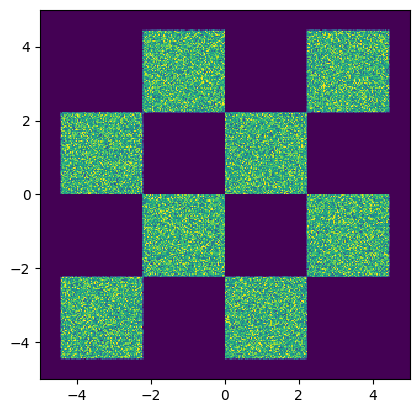

In [9]:
# Visualize the generated data distribution
samples = np.array(data)

H=plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)))
cmin = 0.0
cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()
norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

_ = plt.hist2d(samples[:,0], samples[:,1], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

# set equal ratio of axes
plt.gca().set_aspect('equal', adjustable='box')


plt.show()

## 3. Model and Loss Definition

We define the velocity field model (an MLP), the loss function, and the optimizer for training the flow-matching model.

In [10]:
# Import flow matching components and utilities
from gensbi.recipes import UnconditionalFlowPipeline
from gensbi.models.flux1joint import Flux1JointParams, Flux1Joint

In [11]:
# params = Flux1JointParams(
#             in_channels=1,
#             vec_in_dim=None,
#             mlp_ratio=3.0,
#             num_heads=4,
#             depth_single_blocks=8,
#             axes_dim=[10],
#             condition_dim=[2],
#             qkv_bias=True,
#             rngs=nnx.Rngs(0),
#             dim_joint=2,
#             theta=10,
#             guidance_embed=False,
#             param_dtype=jnp.float32,
#         )

params = Flux1JointParams(
            in_channels=1,
            vec_in_dim=None,
            mlp_ratio=3.0,
            num_heads=4,
            depth_single_blocks=8,
            axes_dim=[10],
            condition_dim=[2],
            qkv_bias=True,
            rngs=nnx.Rngs(0),
            dim_joint=2,
            id_embedding_strategy='absolute',
            guidance_embed=False,
            param_dtype=jnp.float32,
        )

model = Flux1Joint(params)

In [12]:
training_config = UnconditionalFlowPipeline.get_default_training_config()
training_config["checkpoint_dir"] = checkpoint_dir


pipeline = UnconditionalFlowPipeline(model,
    train_dataset_batched,
    val_dataset_batched,
    2,
    training_config=training_config)

In [13]:
# Restore the model from checkpoint if requested
if restore_model:
    pipeline.restore_model()

In [14]:
model_params = nnx.state(pipeline.model, nnx.Param)
total_params  = sum(np.prod(x.shape) for x in jax.tree_util.tree_leaves(model_params))
print(f"Total model parameters: {total_params}")

Total model parameters: 263273


## 4. Training Loop

This section defines the training and validation steps, and runs the training loop if enabled. Early stopping and learning rate scheduling are used for efficient training.

In [15]:
if train_model:
    # Train the model
    pipeline.train(nnx.Rngs(0), nsteps=10_000)

100%|██████████| 10000/10000 [07:01<00:00, 23.72it/s, counter=0, loss=3.7909, ratio=1.0003, val_loss=3.4321] 

Saved model to checkpoint


## 5. Sampling from the Model

In this section, we sample trajectories from the trained flow-matching model and visualize the results at different time steps.

### sample the model

In [16]:
key = jax.random.PRNGKey(42)
T = jnp.linspace(0,1,10)  # sample times
sol = pipeline.sample(key, nsamples=500_000, time_grid=T)

In [18]:
sol.shape

(10, 500000, 2, 1)

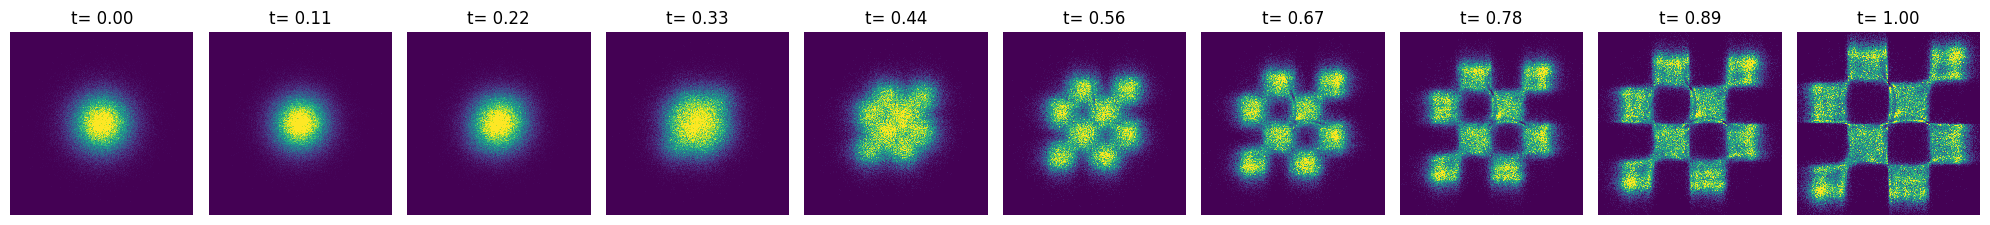

In [20]:
# Visualize the sampled trajectories at different time steps
sol = np.array(sol)  # convert to numpy array
T = np.array(T)  # convert to numpy array

fig, axs = plt.subplots(1, 10, figsize=(20,20))

for i in range(10):
    H = axs[i].hist2d(sol[i,:,0,0], sol[i,:,1,0], 300, range=((-5,5), (-5,5)))

    cmin = 0.0
    cmax = jnp.quantile(jnp.array(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)

    _ = axs[i].hist2d(sol[i,:,0,0], sol[i,:,1,0], 300, range=((-5,5), (-5,5)), norm=norm, cmap="viridis")

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
plt.show()

## 6. Marginal and Trajectory Visualization

We visualize the marginal distributions and sample trajectories from the model.

In [21]:
# Import plotting utility for marginals
from gensbi.utils.plotting import plot_marginals

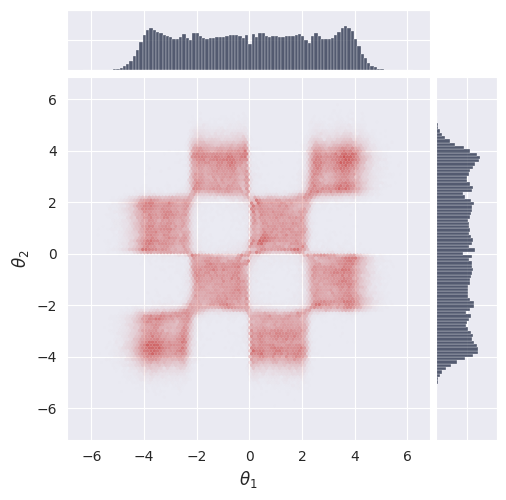

In [24]:
# Plot the marginal distribution of the final samples
plot_marginals(sol[-1,...,0], plot_levels=False, gridsize=100, backend="seaborn")
plt.show()

In [ ]:
# Sample and visualize trajectories with finer time resolution
batch_size = 1000
T = jnp.linspace(0,1,50)  # sample times

sol = pipeline.sample(key, nsamples=batch_size, time_grid=T)

In [25]:
# Import plotting utility for trajectories
from gensbi.utils.plotting import plot_trajectories

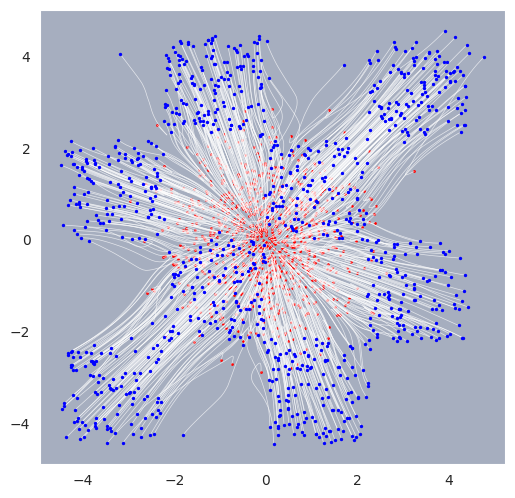

In [ ]:
# Plot sampled trajectories
fig, ax = plot_trajectories(sol)
plt.grid(False)
plt.show()